<a href="https://colab.research.google.com/github/BendelHybrid/BANK-RATES-RETIREMENT/blob/main/Delta_State_Polling_Unit_Data_Analysis_and_Outlier_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Main DataFrame columns: Index(['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Accredited_Voters',
       'Registered_Voters', 'Results_Found', 'Transcription_Count',
       'Result_Sheet_Stamped', 'Result_Sheet_Corrected',
       'Result_Sheet_Invalid', 'Result_Sheet_Unclear', 'Result_Sheet_Unsigned',
       'APC', 'LP', 'PDP', 'NNPP', 'Results_File'],
      dtype='object')
Latitude/Longitude DataFrame columns: Index(['name', 'Ward', 'local_government_name', 'state_name',
       'location.latitude', 'location.longitude'],
      dtype='object')
The outlier scores and top 3 outliers for each party have been saved to outlier_scores.xlsx


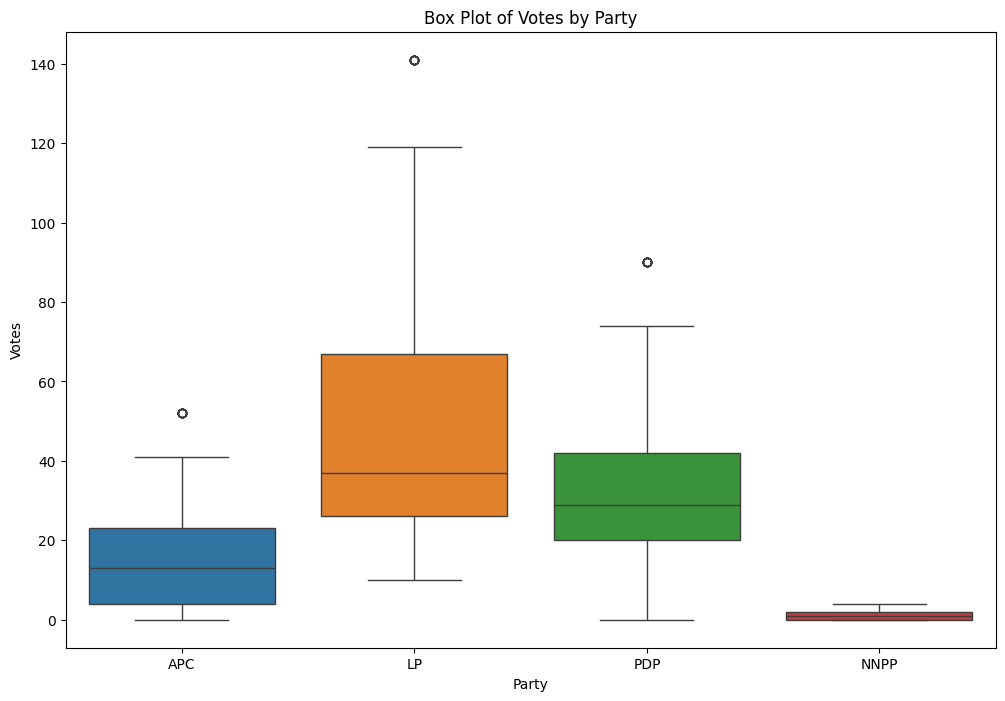

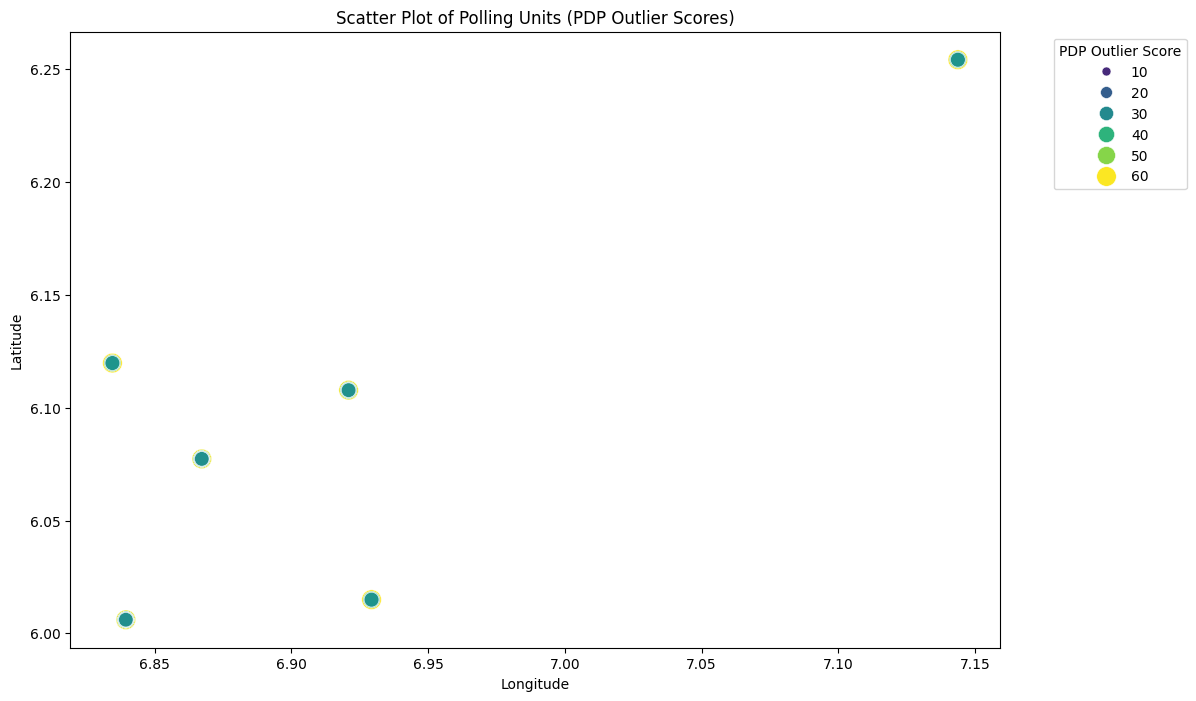

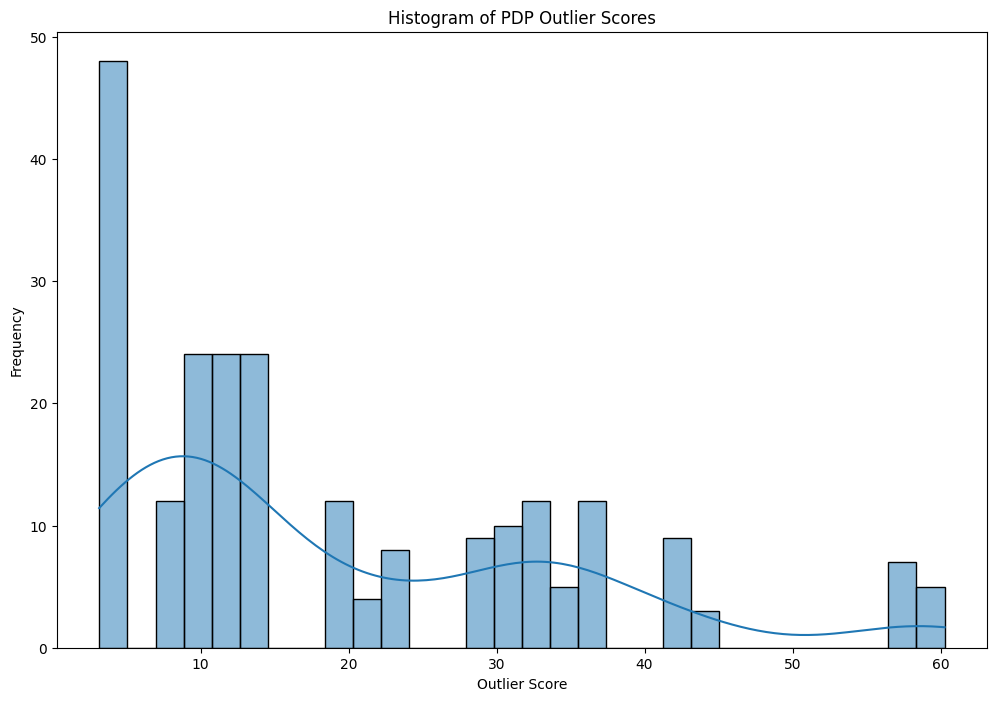

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

# Load the main dataset and the dataset with lat/lon information
main_df = pd.read_csv('/content/DELTA_crosschecked.csv')
lat_lon_df = pd.read_csv('/content/polling-units.csv')

# Print columns to confirm they are correctly loaded
print("Main DataFrame columns:", main_df.columns)
print("Latitude/Longitude DataFrame columns:", lat_lon_df.columns)

# Merge the datasets on the common column (Ward)
df = pd.merge(main_df, lat_lon_df, on='Ward')

# Extract latitude and longitude columns
lat_lon = df[['location.latitude', 'location.longitude']].values

# Define the radius for neighbors (in kilometers)
radius_km = 1.0

# Create a function to compute the geodesic distance matrix
def geodesic_distance_matrix(locations):
    n = len(locations)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = geodesic(locations[i], locations[j]).km
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

# Compute the geodesic distance matrix
geo_dist_matrix = geodesic_distance_matrix(lat_lon)

# Create a list to store the outlier scores and neighbor information
results = []

# Iterate over each polling unit to calculate the outlier scores
for index, row in df.iterrows():
    # Find neighboring polling units within the specified radius
    neighbors = df[(geo_dist_matrix[index] <= radius_km) & (df.index != index)]

    # Calculate the outlier score for each party
    apc_outlier = abs(row['APC'] - neighbors['APC'].mean()) if not neighbors.empty else 0
    lp_outlier = abs(row['LP'] - neighbors['LP'].mean()) if not neighbors.empty else 0
    pdp_outlier = abs(row['PDP'] - neighbors['PDP'].mean()) if not neighbors.empty else 0
    nnpp_outlier = abs(row['NNPP'] - neighbors['NNPP'].mean()) if not neighbors.empty else 0

    # Store the results
    results.append({
        'PU-Code': row['PU-Code'],  # Adjust this if needed
        'PU-Name': row['PU-Name'],  # Add PU-Name column
        'Ward': row['Ward'],        # Add Ward column
        'Latitude': row['location.latitude'],
        'Longitude': row['location.longitude'],
        'APC_outlier': apc_outlier,
        'LP_outlier': lp_outlier,
        'PDP_outlier': pdp_outlier,
        'NNPP_outlier': nnpp_outlier,
        'Neighbors': neighbors['PU-Code'].tolist()  # Adjust this if needed
    })

# Convert the results list to a DataFrame
outlier_scores = pd.DataFrame(results)

# Sort the dataset by the outlier scores for each party
sorted_apc = outlier_scores.sort_values(by='APC_outlier', ascending=False).head(3)
sorted_lp = outlier_scores.sort_values(by='LP_outlier', ascending=False).head(3)
sorted_pdp = outlier_scores.sort_values(by='PDP_outlier', ascending=False).head(3)
sorted_nnpp = outlier_scores.sort_values(by='NNPP_outlier', ascending=False).head(3)

# Save the outlier scores and sorted results to an Excel file
output_file_path = 'outlier_scores.xlsx'
with pd.ExcelWriter(output_file_path) as writer:
    outlier_scores.to_excel(writer, sheet_name='Outlier Scores', index=False)
    sorted_apc.to_excel(writer, sheet_name='Top 3 APC Outliers', index=False)
    sorted_lp.to_excel(writer, sheet_name='Top 3 LP Outliers', index=False)
    sorted_pdp.to_excel(writer, sheet_name='Top 3 PDP Outliers', index=False)
    sorted_nnpp.to_excel(writer, sheet_name='Top 3 NNPP Outliers', index=False)

print(f"The outlier scores and top 3 outliers for each party have been saved to {output_file_path}")

# Visualization

# Box Plot for each party's outlier scores
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[['APC', 'LP', 'PDP', 'NNPP']])
plt.title('Box Plot of Votes by Party')
plt.xlabel('Party')
plt.ylabel('Votes')
plt.savefig('box_plot_votes_by_party.png')
plt.show()

# Scatter Plot for latitude vs longitude with outlier scores
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Longitude', y='Latitude', hue='PDP_outlier', data=outlier_scores, palette='viridis', size='PDP_outlier', sizes=(20, 200))
plt.title('Scatter Plot of Polling Units (PDP Outlier Scores)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='PDP Outlier Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('scatter_plot_pdp_outliers.png')
plt.show()

# Histogram of PDP outlier scores
plt.figure(figsize=(12, 8))
sns.histplot(outlier_scores['PDP_outlier'], bins=30, kde=True)
plt.title('Histogram of PDP Outlier Scores')
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.savefig('histogram_pdp_outlier_scores.png')
plt.show()



In [ ]:
# Save the cleaned data with latitude and longitude to a CSV file
output_cleaned_file_path = 'cleaned_dataset_with_lat_lon.csv'
df.to_csv(output_cleaned_file_path, index=False)

print(f"The cleaned dataset with latitude and longitude has been saved to {output_cleaned_file_path}")

The cleaned dataset with latitude and longitude has been saved to cleaned_dataset_with_lat_lon.csv


In [ ]:
# Histogram of PDP outlier scores
plt.figure(figsize=(12, 8))
sns.histplot(outlier_scores['PDP_outlier'], bins=30, kde=True)
plt.title('Histogram of PDP Outlier Scores')
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.savefig('histogram_pdp_outlier_scores.png')
plt.show()